# An example of RNN
In this example, we hope to predict the numerical values that follow the sequence. We use the sine function as this sequence.
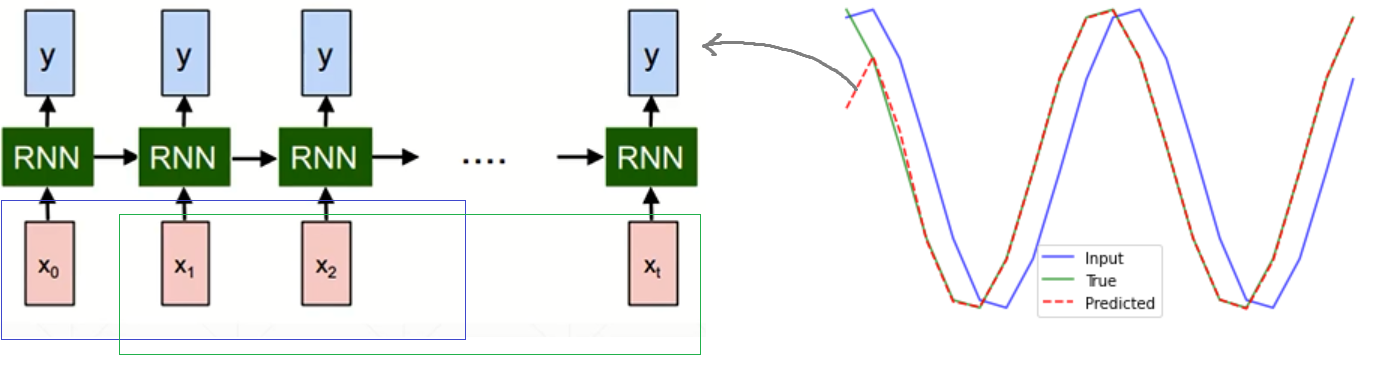


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# random seed
torch.manual_seed(42)

## Create a RNN model manually


In [2]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        
        # RNN params
        self.W_xh = nn.Linear(input_size, hidden_size) ## x(t)->h(t)
        self.W_hh = nn.Linear(hidden_size, hidden_size)##h(t-1)->h(t)
        self.W_hy = nn.Linear(hidden_size, output_size)##h(t)->y(t) :predict of x(t)
        self.tanh = nn.Tanh()
        
    def forward(self, x, hidden=None):
        # x shape: (seq_len, batch_size, input_size)
        # hidden shape: (batch_size, hidden_size)
        
        if hidden is None:
            hidden = torch.zeros(x.size(1), self.hidden_size)
        
        outputs = []
        for t in range(x.size(0)):  # travers time step
            hidden = self.tanh(self.W_xh(x[t]) + self.W_hh(hidden))
            output = self.W_hy(hidden)
            outputs.append(output)
        
        outputs = torch.stack(outputs)  # (seq_len, batch_size, output_size)
        return outputs, hidden

# init set
input_size = 1
hidden_size = 32
output_size = 1
seq_len = 20
batch_size = 16

# create model
model = SimpleRNN(input_size, hidden_size, output_size)
print(model)

SimpleRNN(
  (W_xh): Linear(in_features=1, out_features=32, bias=True)
  (W_hh): Linear(in_features=32, out_features=32, bias=True)
  (W_hy): Linear(in_features=32, out_features=1, bias=True)
  (tanh): Tanh()
)


In [4]:
# use PyTorch's RNN
class PyTorchRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(PyTorchRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=False)
        self.fc = nn.Linear(hidden_size, output_size) # there is no output layer in nn.RNN, extra output layer is needed
        
    def forward(self, x, hidden=None):
        # x shape: (seq_len, batch_size, input_size)
        if hidden is None:
            hidden = torch.zeros(self.num_layers, x.size(1), self.hidden_size)
        
        out, hidden = self.rnn(x, hidden)
        out = self.fc(out)  # (seq_len, batch_size, output_size)
        return out, hidden

# create PyTorch RNN model
pytorch_model = PyTorchRNN(input_size, hidden_size, output_size)
print(pytorch_model)

PyTorchRNN(
  (rnn): RNN(1, 32)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [5]:
# Create sin() wave as input
def generate_sine_wave_data(seq_len=50, num_samples=1000):
    t = np.linspace(0, 4*np.pi, seq_len+1)
    data = []
    
    for i in range(num_samples):
        phase = np.random.uniform(0, 2*np.pi)
        sine_wave = np.sin(t + phase)
        data.append(sine_wave)
    
    data = np.array(data)  # (num_samples, seq_len+1)
    
    # first seq_len points as INPUT，last seq_len points as TARGET（use t to predict t+1）
    X = data[:, :-1].reshape(num_samples, seq_len, 1)
    y = data[:, 1:].reshape(num_samples, seq_len, 1)
    
    return torch.FloatTensor(X), torch.FloatTensor(y)

# get data
X, y = generate_sine_wave_data(seq_len=20, num_samples=1000)
print(f"X shape: {X.shape}, y shape: {y.shape}")

# split train-set and test-set
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

print(f"训练集大小: {X_train.shape}, 测试集大小: {X_test.shape}")

X shape: torch.Size([1000, 20, 1]), y shape: torch.Size([1000, 20, 1])
训练集大小: torch.Size([800, 20, 1]), 测试集大小: torch.Size([200, 20, 1])


In [6]:
# train
def train_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        model.train()
        
        # transpose the dims: (batch_size, seq_len, input_size) -> (seq_len, batch_size, input_size)
        X_train_t = X_train.transpose(0, 1)
        y_train_t = y_train.transpose(0, 1)
        
        # forward
        outputs, _ = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # loss
        model.eval()
        with torch.no_grad():
            X_test_t = X_test.transpose(0, 1)
            y_test_t = y_test.transpose(0, 1)
            test_outputs, _ = model(X_test_t)
            test_loss = criterion(test_outputs, y_test_t)
        
        train_losses.append(loss.item())
        test_losses.append(test_loss.item())
        
        if epoch % 20 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {loss.item():.6f}, Test Loss: {test_loss.item():.6f}')
    
    return train_losses, test_losses

# train
print("开始训练RNN模型...")
train_losses, test_losses = train_model(pytorch_model, X_train, y_train, X_test, y_test, epochs=200, lr=0.001)

开始训练RNN模型...
Epoch [0/200], Train Loss: 0.571503, Test Loss: 0.561675
Epoch [20/200], Train Loss: 0.369651, Test Loss: 0.356192
Epoch [40/200], Train Loss: 0.083695, Test Loss: 0.086190
Epoch [60/200], Train Loss: 0.066850, Test Loss: 0.067318
Epoch [80/200], Train Loss: 0.057920, Test Loss: 0.057569
Epoch [100/200], Train Loss: 0.053418, Test Loss: 0.053274
Epoch [120/200], Train Loss: 0.050112, Test Loss: 0.049944
Epoch [140/200], Train Loss: 0.047144, Test Loss: 0.046910
Epoch [160/200], Train Loss: 0.044405, Test Loss: 0.044163
Epoch [180/200], Train Loss: 0.041843, Test Loss: 0.041590


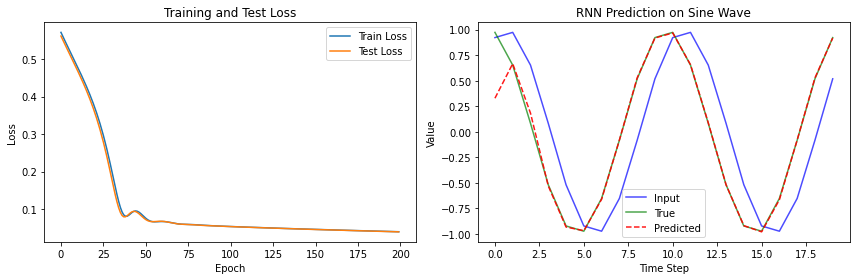

In [7]:
# draw train loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Test Loss')

# draw predict result
plt.subplot(1, 2, 2)
pytorch_model.eval()
with torch.no_grad():
    # choose one sample
    test_sample = X_test[0:1]  # (1, seq_len, 1)
    test_target = y_test[0:1]  # (1, seq_len, 1)
    
    # predict
    test_sample_t = test_sample.transpose(0, 1)  # (seq_len, 1, 1)
    prediction, _ = pytorch_model(test_sample_t)
    prediction = prediction.transpose(0, 1)  # (1, seq_len, 1)
    
    # visualize
    time_steps = range(20)
    plt.plot(time_steps, test_sample[0].numpy(), 'b-', label='Input', alpha=0.7)
    plt.plot(time_steps, test_target[0].numpy(), 'g-', label='True', alpha=0.7)
    plt.plot(time_steps, prediction[0].numpy(), 'r--', label='Predicted', alpha=0.9)
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.title('RNN Prediction on Sine Wave')

plt.tight_layout()
plt.show()

In [8]:
# A complete example
if __name__ == "__main__":
    # 设置设备
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"使用设备: {device}")
    
    # gen date
    X, y = generate_sine_wave_data(seq_len=20, num_samples=1000)
    X, y = X.to(device), y.to(device)
    
    # split data
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    
    # create model
    input_size = 1
    hidden_size = 32
    output_size = 1
    
    model = PyTorchRNN(input_size, hidden_size, output_size).to(device)
    
    # train
    train_losses, test_losses = train_model(
        model, X_train, y_train, X_test, y_test, 
        epochs=200, lr=0.001
    )
    
    print("训练完成!")
    
    # loss
    print(f"最终训练损失: {train_losses[-1]:.6f}")
    print(f"最终测试损失: {test_losses[-1]:.6f}")

使用设备: cpu
Epoch [0/200], Train Loss: 0.533859, Test Loss: 0.519726
Epoch [20/200], Train Loss: 0.304877, Test Loss: 0.288129
Epoch [40/200], Train Loss: 0.082807, Test Loss: 0.081131
Epoch [60/200], Train Loss: 0.059486, Test Loss: 0.056255
Epoch [80/200], Train Loss: 0.051035, Test Loss: 0.048438
Epoch [100/200], Train Loss: 0.046846, Test Loss: 0.044601
Epoch [120/200], Train Loss: 0.043175, Test Loss: 0.041241
Epoch [140/200], Train Loss: 0.040031, Test Loss: 0.038345
Epoch [160/200], Train Loss: 0.037268, Test Loss: 0.035796
Epoch [180/200], Train Loss: 0.034799, Test Loss: 0.033503
训练完成!
最终训练损失: 0.032677
最终测试损失: 0.031519
